In [136]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.dish_bin.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *
from spatial_scene_grammars.dataset import *
from spatial_scene_grammars.torch_utils import calculate_mmd

from utils import get_observed_node_sets

import meshcat
import meshcat.geometry as meshcat_geom

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()
vis.delete()
base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
'''
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))
'''

Meshcat url:  http://127.0.0.1:7005/static/


'\nfrom IPython.display import HTML\nHTML("""\n    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">\n    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>\n</div>\n""".format(url=meshcat_url))\n'

In [138]:
# Load in datasets.
observed_node_sets, observed_node_sets_outliers = get_observed_node_sets(reconvert=True)
# One of the 10-element appears to be breaking the multiprocessing stuff,
# so I need to cut them out for now...
observed_node_sets = [o for o in observed_node_sets if len(o) <= 9]
print(len(observed_node_sets), " inlier examples and ", len(observed_node_sets_outliers), " outlier examples")

68  inlier examples and  7  outlier examples


In [85]:
total_of_each_type = {"DishBin": 0}
for model_type_set in [PlateModels, CupModels, BowlModels]:
    for model_type in model_type_set:
        total_of_each_type[model_type.__name__] = 0
for observed_nodes in observed_node_sets:
    for node in observed_nodes:
        total_of_each_type[type(node).__name__] += 1
print(total_of_each_type)

{'DishBin': 68, 'sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring': 34, 'sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado': 26, 'sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise': 44, 'sink:plates_cups_and_bowls:cups:Cole_Hardware_Mug_Classic_Blue': 29, 'sink:plates_cups_and_bowls:cups:Room_Essentials_Mug_White_Yellow': 39, 'sink:plates_cups_and_bowls:cups:Threshold_Porcelain_Coffee_Mug_All_Over_Bead_White': 33, 'sink:plates_cups_and_bowls:bowls:Bradshaw_International_11642_7_Qt_MP_Plastic_Bowl': 27, 'sink:plates_cups_and_bowls:bowls:Cole_Hardware_Bowl_Scirocco_YellowBlue': 31, 'sink:plates_cups_and_bowls:bowls:Room_Essentials_Bowl_Turquiose': 31}


In [5]:
# Draw a random sample from the grammar with its initial params and visualize it.
#torch.random.manual_seed(5)
pyro.set_rng_seed(42)
grammar = SpatialSceneGrammar(
    root_node_type = DishBin,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.5, 0., 0.]))
)
supertree = grammar.make_super_tree(max_recursion_depth=10)
print("Supertree size ", len(supertree.nodes))

sampled_tree = grammar.sample_tree(detach=True)
observed_nodes = sampled_tree.get_observed_nodes()

vis["initial_sample"].delete()
draw_scene_tree_contents_meshcat(sampled_tree, zmq_url=vis.window.zmq_url, prefix="initial_sample/contents")
draw_scene_tree_structure_meshcat(sampled_tree, zmq_url=vis.window.zmq_url, prefix="initial_sample/structure", node_sphere_size=0.01)

[2022-01-12 23:42:08.641] [console] [warning] FindResource ignoring DRAKE_RESOURCE_ROOT='/home/gizatt/drake' because it does not contain a 'drake' subdirectory.


Supertree size  571


In [6]:
# Parse that dummy observation; it should have only one unique parse, since there's only one
# object. Use no pose proposals, as this grammar is pure-dependency.
trees = infer_mle_tree_with_mip_from_proposals(
    grammar, observed_nodes, {}, verbose=1, N_solutions=5, max_recursion_depth=10
)
vis["sampled_scene_parse"].delete()
draw_scene_tree_contents_meshcat(trees[0], zmq_url=vis.window.zmq_url, prefix="sampled_scene_parse/contents")
for k, tree in enumerate(trees[:3]):
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="sampled_scene_parse/structure/%d" % k, node_sphere_size=0.01)

Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Wed Jan 12 23:42:09 2022

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 1985 rows, 699 columns and 4607 nonzeros
Model fingerprint: 0xc252ebd7
Variable types: 0 continuous, 699 integer (699 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+00]
  Objective range  [5e-01, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 1e+00]
Presolve removed 1985 rows and 699 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 12 available processors)

Solution count 1: 4.06044 

Optimal solution found (tolerance 1.00e-03)
Best objective 4.060443570577e+00, best bound 4.060443570577e+00, gap 0.0000%

Building tree for sol 0...


In [7]:
# Check we recover the GT parse tree for that  random scene.
print("Best parse score: ", trees[0].score(include_continuous=True))
print("GT tree score: ", sampled_tree.score(include_continuous=True))
deviations = []
for node in trees[0]:
    R = node.rotation.detach().numpy()
    deviations.append(np.sum(R.T.dot(R) - np.eye(3)))
print("Max deviation: ", np.max(np.abs(deviations)))

Best parse score:  tensor([-4.0604])
GT tree score:  tensor([-4.0604])
Max deviation:  1.0386656812411132e-15


# Approximate EM parameter fitting with IP parser

In [8]:
em = EMWrapper(grammar, observed_node_sets, parsing_strategy="ip_noproposals", do_nlp_refinement=False)
em.do_iterated_em_fitting(em_iterations=30, tqdm=tqdm, N_solutions=10, num_workers=10, max_recursion_depth=10)

EM Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

SpatialSceneGrammar(
  (params_by_node_type): ModuleDict(
    (sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring): None
    (sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise): None
    (TerminalObject): ConstrainedParameter()
    (Plate): None
    (TerminalCup): ConstrainedParameter()
    (ObjectsOnPlate): ConstrainedParameter()
    (sink:plates_cups_and_bowls:cups:Threshold_Porcelain_Coffee_Mug_All_Over_Bead_White): None
    (TerminalBowl): ConstrainedParameter()
    (DishBin): ConstrainedParameter()
    (sink:plates_cups_and_bowls:cups:Room_Essentials_Mug_White_Yellow): None
    (sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado): None
    (sink:plates_cups_and_bowls:bowls:Room_Essentials_Bowl_Turquiose): None
    (Object): ConstrainedParameter()
    (sink:plates_cups_and_bowls:cups:Cole_Hardware_Mug_Classic_Blue): None
    (sink:plates_cups_and_bowls:bowls:Cole_Hardware_Bowl_Scirocco_YellowBlue): None
    (Bowl): None


In [9]:
# Save our grammar params
torch.save(grammar.state_dict(), "fit_grammar.torch")
with open("fit_em.pickle", "wb") as fp:
    pickle.dump(em, fp)

# Plotting and inspection of EM fitting process

In [8]:
with open("fit_em.pickle", "rb") as fp:
    em = pickle.load(fp)
assert len(em.grammar_iters) > 0

Before:  -657.0322913699564 After:  -335.07476419453064
Before:  -657.0322913699564 After:  -335.07476419453064


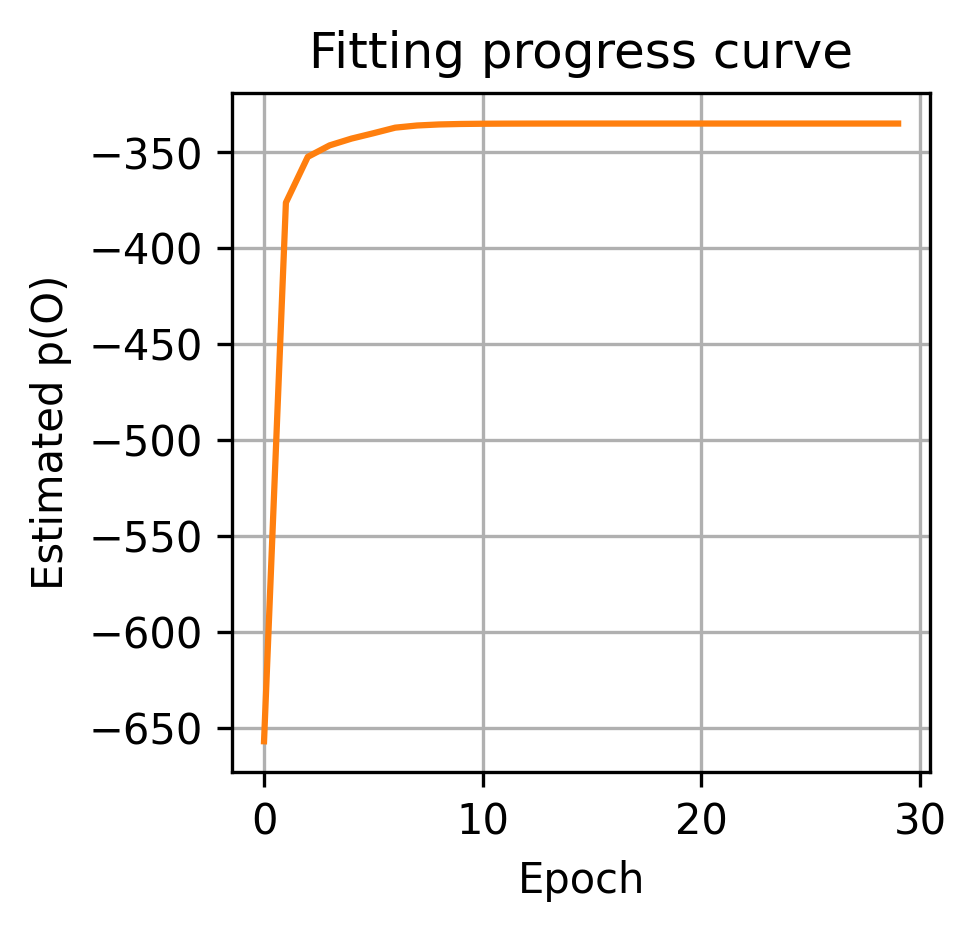

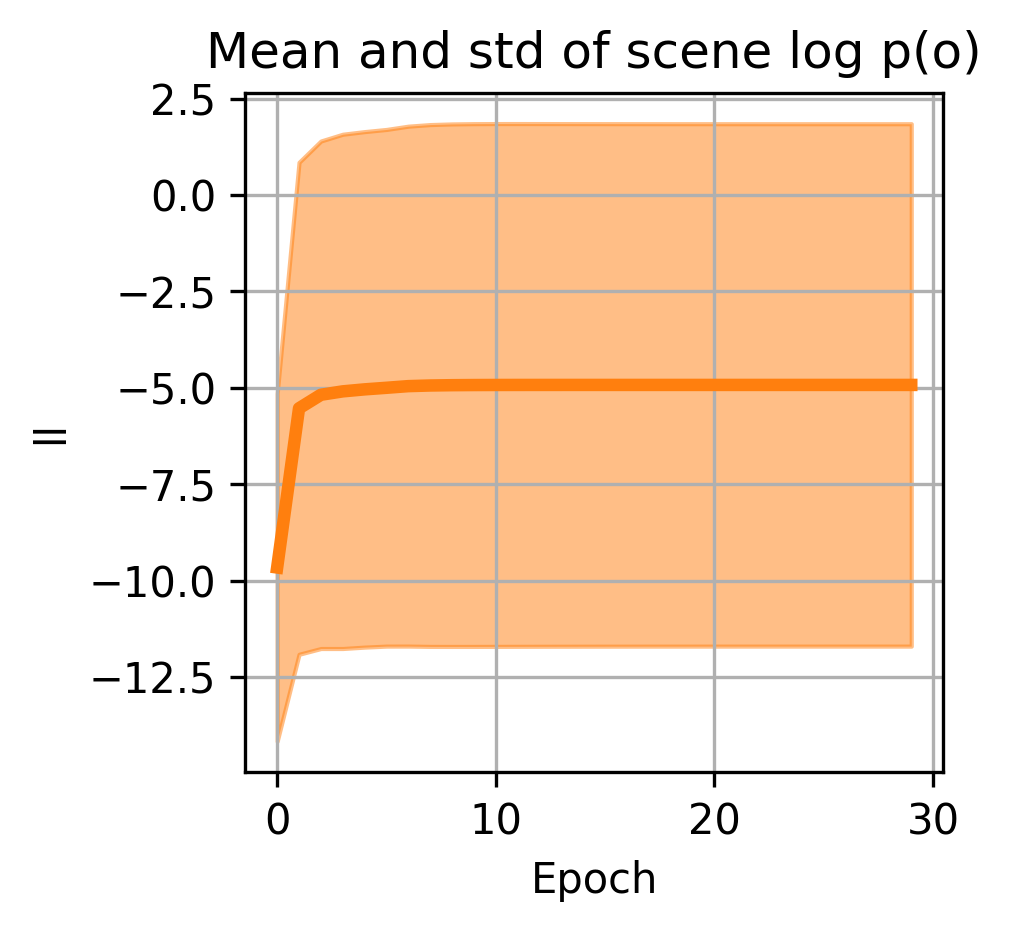

In [75]:
plt.figure(dpi=300).set_size_inches(3, 3)
totals = [np.sum(x) for x in em.log_evidence_iters]
plt.plot(totals, color="tab:orange")
plt.xlabel("Epoch")
plt.grid()
plt.ylabel("Estimated p(O)")
plt.title("Fitting progress curve")
print("Before: ", totals[0], "After: ", totals[-1])

# Slightly different: what's mean + avg p(o) for individual os look like?
plt.figure(dpi=300).set_size_inches(3, 3)
xs = range(len(em.log_evidence_iters))
means = np.array([np.mean(x) for x in em.log_evidence_iters])
stds = np.array([np.std(x) for x in em.log_evidence_iters])
plt.plot(xs, means, linewidth=3, color="tab:orange")
plt.fill_between(xs, means-stds, means+stds, alpha=0.5, color="tab:orange")
plt.xlabel("Epoch")
plt.grid()
plt.ylabel("ll")
plt.title("Mean and std of scene log p(o)")

In [10]:
# For each step over the fitting process, draw a population of samples from the
# candidate grammar, and collect the population of each terminal object type. Calculate
# MMDs against the corresponding populations of observed object types in the dataset.

# Precompute populations for dataset, and the dictionary we'll use to
# store the distance measurements.
observed_population_by_type = {}
for observed_nodes in observed_node_sets:
    for observed_node in observed_nodes:
        key = type(observed_node).__name__
        if key not in observed_population_by_type.keys():
            observed_population_by_type[key] = []
        observed_population_by_type[key].append(observed_node.tf)
for key, value in observed_population_by_type.items():
    observed_population_by_type[key] = torch.stack(value)

mmds_by_type = {key: [] for key in observed_population_by_type.keys()}

# For each EM iteration...
N_samples = 1000
mmd_alphas = [0.01, 0.05, 0.1, 0.5, 1.]
for k, grammar_state_dict in tqdm(enumerate(em.grammar_iters), total=len(em.grammar_iters)):
    grammar.load_state_dict(grammar_state_dict)
    # Build a population of observed nodes.
    sampled_population_by_type = {key: [] for key in observed_population_by_type.keys()}
    for k in range(N_samples):
        observed_nodes = grammar.sample_tree(detach=True).get_observed_nodes()
        for observed_node in observed_nodes:
            key = type(observed_node).__name__
            if key not in sampled_population_by_type:
                logging.warning("Sampled object not in observations: %s" % key)
                sampled_population_by_type[key] = []
            sampled_population_by_type[key].append(observed_node.tf)
    for key, value in sampled_population_by_type.items():
        sampled_population_by_type[key] = torch.stack(value)
    # Compute MMDs
    for key in observed_population_by_type.keys():
        observed_pop = observed_population_by_type[key]
        sampled_pop = sampled_population_by_type[key]
        if observed_pop.shape[0] > 0 and sampled_pop.shape[0] > 0:
            mmds_by_type[key].append(
                calculate_mmd(observed_pop, sampled_pop, alphas=mmd_alphas, use_se3_metric=True)
            )
        else:
            logging.warning("%d observed, %d sampled, can't compare." % (observed_pop.shape[0], sampled_pop.shape[0]))
            mmds_by_type[key].append(np.inf)

  0%|          | 0/31 [00:00<?, ?it/s]

Initial: 0.237334 +/- 0.147940
Final: 0.083351 +/- 0.075653


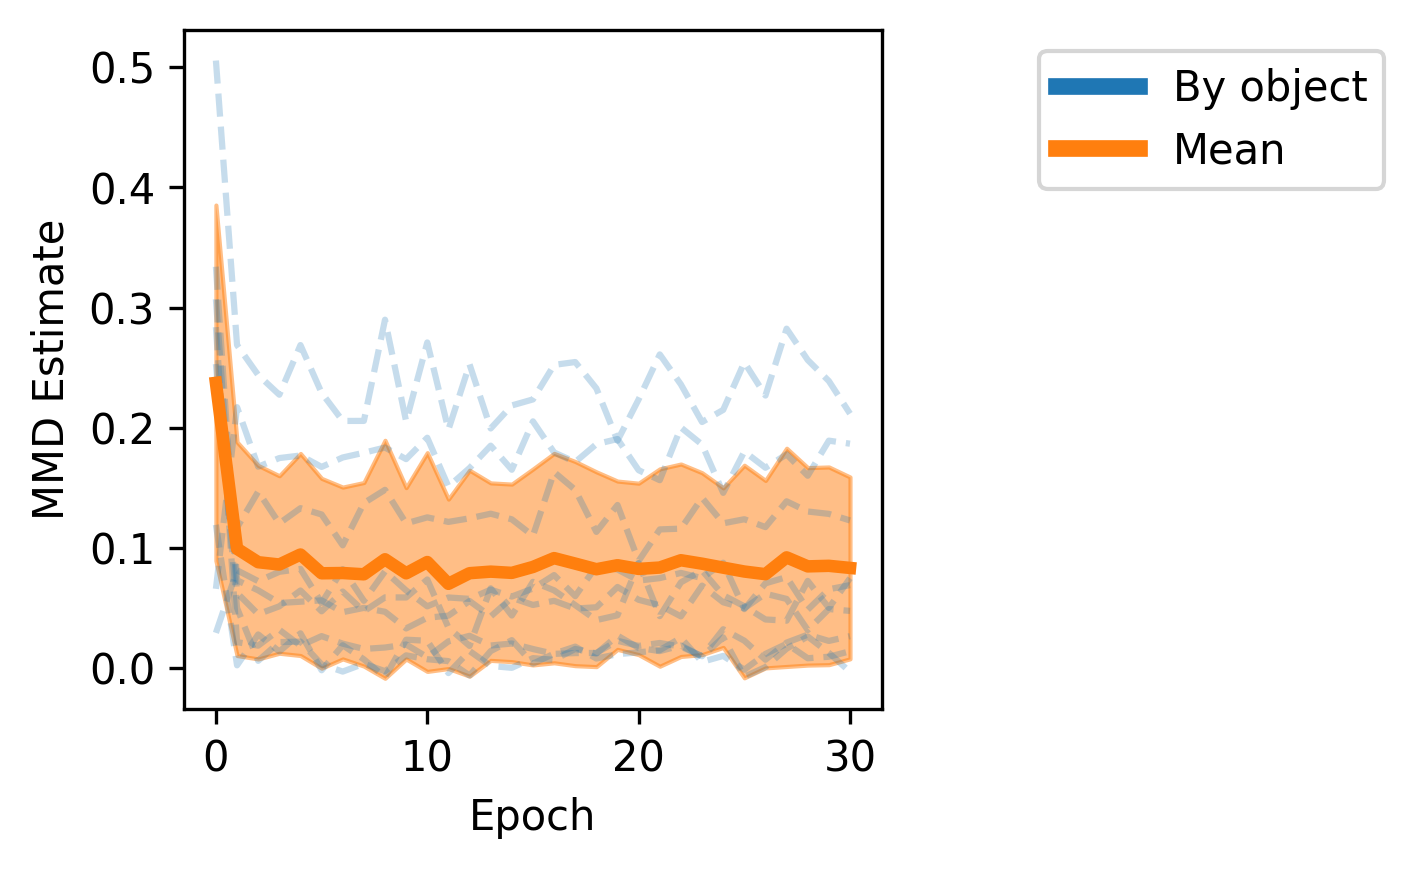

In [66]:
# Plot all of those over time.
plt.figure(dpi=300).set_size_inches(3, 3)



stacked_values = []
for key, value in mmds_by_type.items():
    if key == "DishBin":
        continue
    plt.plot(value, alpha=0.25, linestyle="--", c="tab:blue")
    stacked_values.append(torch.tensor(value))
stacked_values = torch.stack(stacked_values)
xs = range(stacked_values.shape[1])
means = torch.mean(stacked_values, dim=0)
stds = torch.std(stacked_values, dim=0)
plt.plot(xs, means, linewidth=3, color="tab:orange")
plt.fill_between(xs, means-stds, means+stds, alpha=0.5, color="tab:orange")

plt.xlabel("Epoch")
plt.ylabel("MMD Estimate")
# Custom legend
from matplotlib.lines import Line2D
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
custom_lines = [Line2D([0], [0], color="tab:blue", lw=4, label="By object"),
                Line2D([0], [0], color="tab:orange", lw=4, label="Mean")]
plt.gca().legend(handles=custom_lines, bbox_to_anchor=[1.75, 1])

initial_mmds = stacked_values[:, 0]
last_mmds = stacked_values[:, -1]
print("Initial: %f +/- %f" % (torch.mean(initial_mmds), torch.std(initial_mmds)))
print("Final: %f +/- %f" % (torch.mean(last_mmds), torch.std(last_mmds)))


Text(0.5, 1.0, 'Weights of child types of "Object"\nduring EM process')

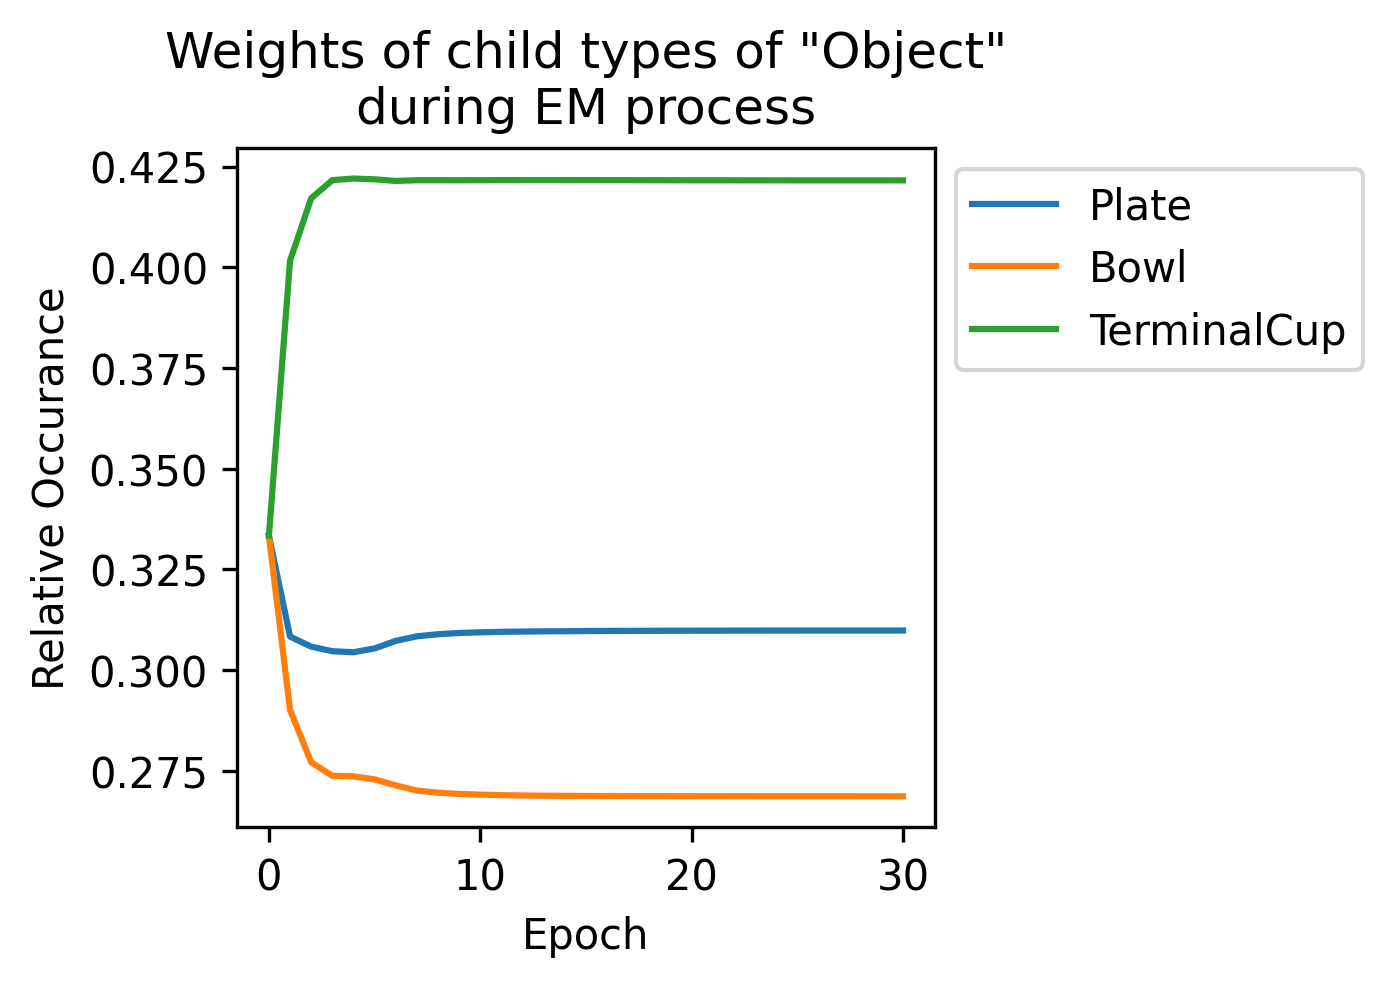

In [12]:
# Extract grammar history for Object and label it appropriately
object_params_history = []
for grammar_state_dict in em.grammar_iters:
    grammar.load_state_dict(grammar_state_dict)
    object_params_history.append(grammar.params_by_node_type["Object"]().detach().numpy())
object_params_history = np.stack(object_params_history)
object_child_types = [rule.child_type.__name__ for rule in Object.generate_rules()]
plt.figure(dpi=300).set_size_inches(3, 3)
for k, child_name in enumerate(object_child_types):
    plt.plot(object_params_history[:, k], label=child_name)
plt.legend(bbox_to_anchor=[1, 1])
plt.xlabel("Epoch")
plt.ylabel("Relative Occurance")
plt.title("Weights of child types of \"Object\"\nduring EM process")

Text(0.5, 1.0, 'Evolution of object offset in bowl\nWith 1/2 standard deviations')

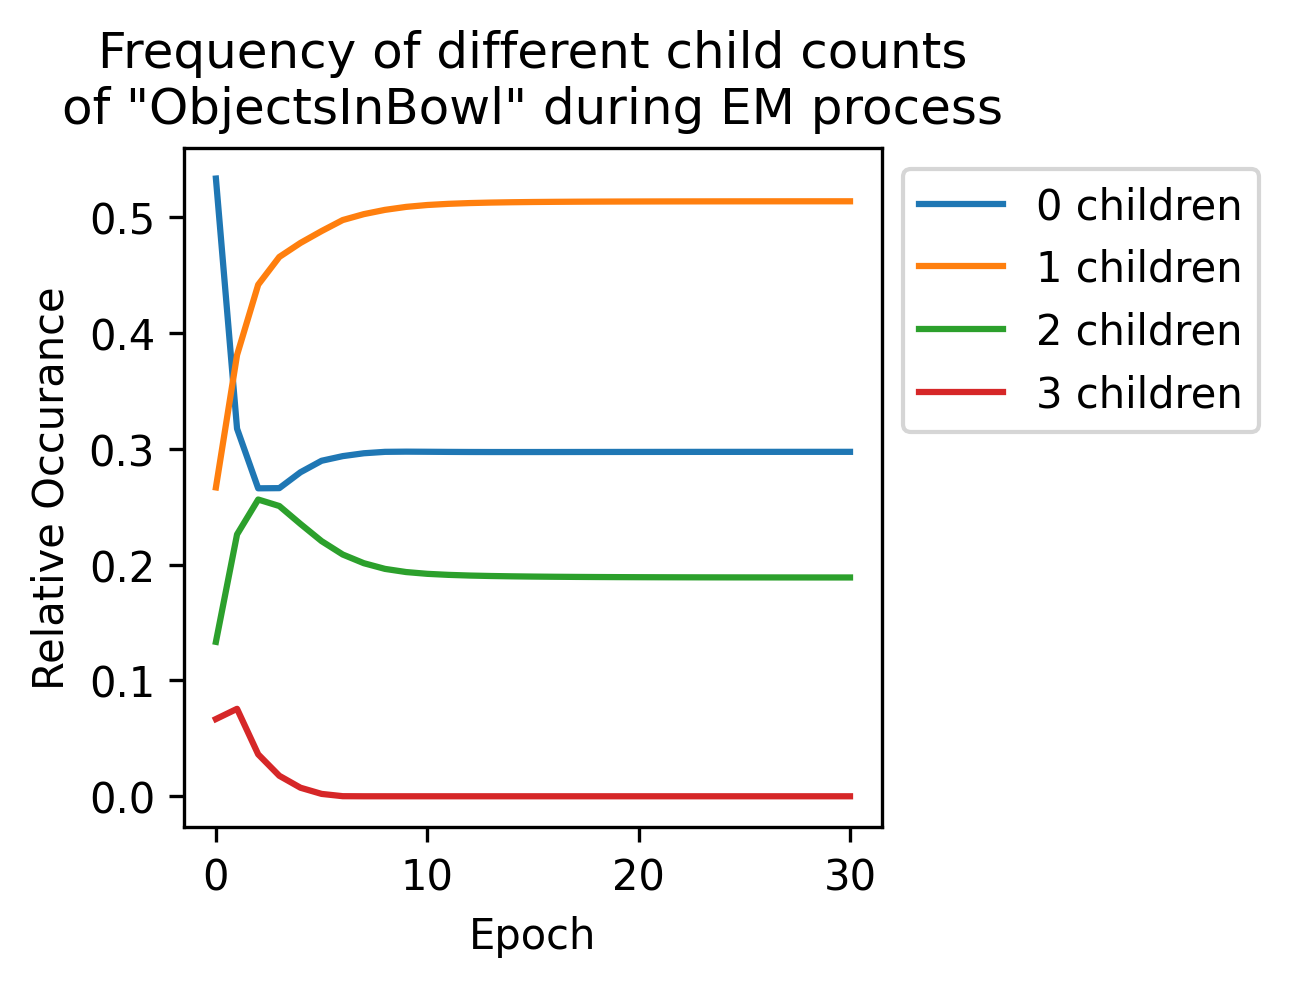

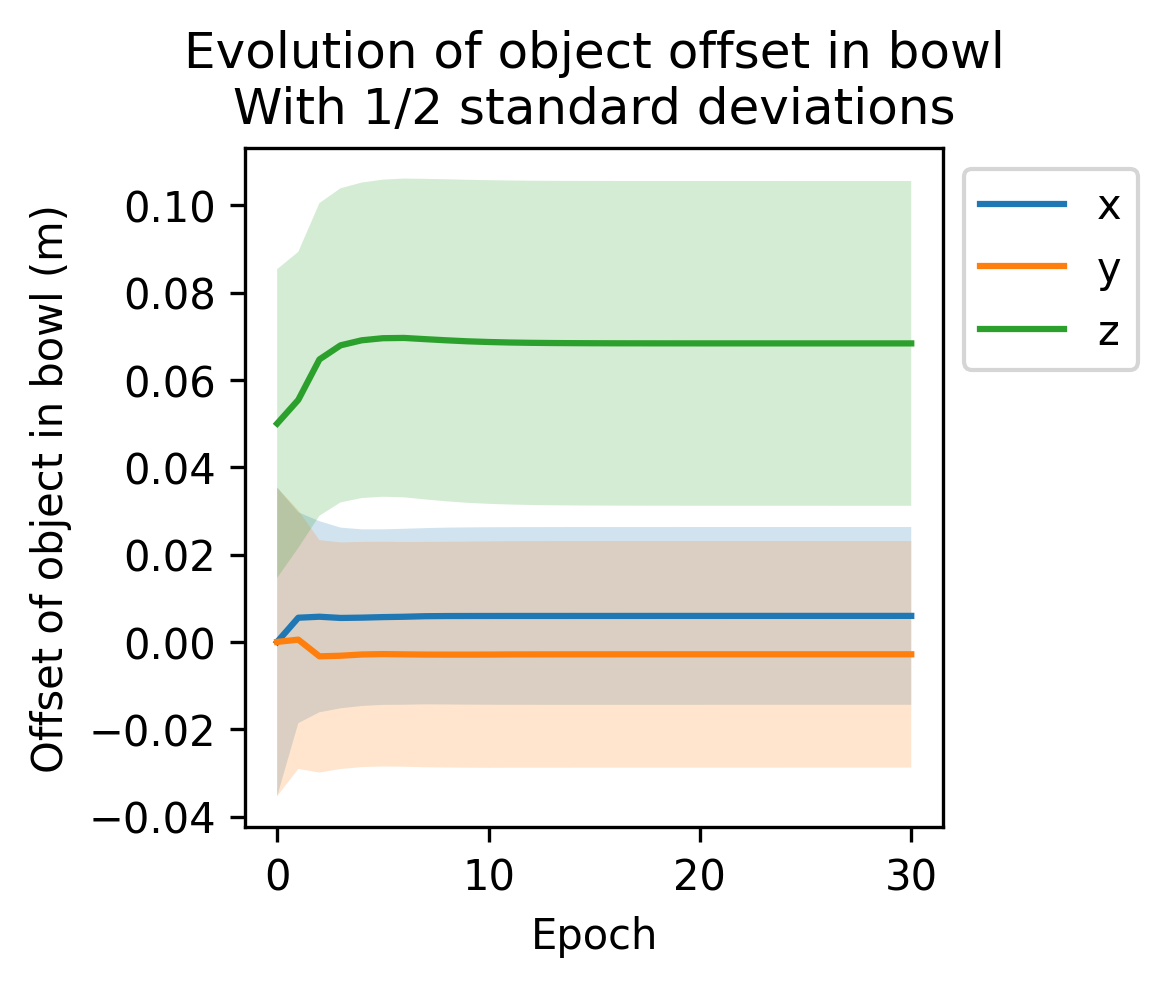

In [13]:
# Extract grammar history for ObjectInBowl and label it appropriately
params_history = []
t_mean_history = []
t_var_history = []
for grammar_state_dict in em.grammar_iters:
    grammar.load_state_dict(grammar_state_dict)
    params_history.append(grammar.params_by_node_type["ObjectsInBowl"]().detach().numpy())
    t_mean_history.append(grammar.rule_params_by_node_type["ObjectsInBowl"][0][0]["mean"]().detach().numpy().copy())
    t_var_history.append(grammar.rule_params_by_node_type["ObjectsInBowl"][0][0]["variance"]().detach().numpy().copy())
params_history = np.stack(params_history)
t_mean_history = np.stack(t_mean_history)
t_var_history = np.stack(t_var_history)
labels = ["%d children" % k for k in range(ObjectsInBowl(torch.eye(4)).max_children + 1)]

plt.figure(dpi=300).set_size_inches(3, 3)
for k, label in enumerate(labels):
    plt.plot(params_history[:, k], label=label)
plt.legend(bbox_to_anchor=[1, 1])
plt.xlabel("Epoch")
plt.ylabel("Relative Occurance")
plt.title("Frequency of different child counts\nof \"ObjectsInBowl\" during EM process")

plt.figure(dpi=300).set_size_inches(3, 3)
t_std_history = np.sqrt(t_var_history)*0.5
for k in range(3):
    xs = range(t_mean_history.shape[0])
    plt.plot(xs, t_mean_history[:, k], label="xyz"[k])
    plt.fill_between(xs, t_mean_history[:, k]-t_std_history[:, k], t_mean_history[:, k]+t_std_history[:, k], alpha=0.2)
plt.xlabel("Epoch")
plt.ylabel("Offset of object in bowl (m)")
plt.legend(bbox_to_anchor=[1, 1])
plt.title("Evolution of object offset in bowl\nWith 1/2 standard deviations")

DishBin : 
Final params:  tensor([2.2251e-308,  1.7311e-01,  1.8593e-01,  4.0614e-01,  1.6001e-01,
         3.1018e-02,  4.3794e-02])
mean tensor([[ 0.0000,  0.0000,  0.1000],
        [-0.0065,  0.0299,  0.0593],
        [-0.0083,  0.0336,  0.0581],
        [-0.0087,  0.0334,  0.0586],
        [-0.0090,  0.0336,  0.0591],
        [-0.0094,  0.0343,  0.0594],
        [-0.0098,  0.0349,  0.0595],
        [-0.0099,  0.0355,  0.0596],
        [-0.0099,  0.0358,  0.0596],
        [-0.0099,  0.0360,  0.0596],
        [-0.0099,  0.0361,  0.0597],
        [-0.0099,  0.0362,  0.0597],
        [-0.0099,  0.0362,  0.0597],
        [-0.0099,  0.0363,  0.0597],
        [-0.0099,  0.0363,  0.0597],
        [-0.0099,  0.0363,  0.0597],
        [-0.0099,  0.0363,  0.0597],
        [-0.0099,  0.0363,  0.0597],
        [-0.0099,  0.0363,  0.0598],
        [-0.0099,  0.0363,  0.0598],
        [-0.0099,  0.0363,  0.0598],
        [-0.0099,  0.0363,  0.0598],
        [-0.0099,  0.0363,  0.0598],
        [-

Object : 
Final params:  tensor([0.3098, 0.2686, 0.4216])


Bowl : 


TerminalBowl : 
Final params:  tensor([0.3034, 0.3483, 0.3483])
ObjectsInBowl : 
Final params:  tensor([2.9738e-01, 5.1370e-01, 1.8891e-01, 8.6653e-24])
mean tensor([[ 0.0000,  0.0000,  0.0500],
        [ 0.0055,  0.0005,  0.0554],
        [ 0.0058, -0.0033,  0.0647],
        [ 0.0055, -0.0032,  0.0679],
        [ 0.0056, -0.0029,  0.0691],
        [ 0.0057, -0.0028,  0.0695],
        [ 0.0058, -0.0029,  0.0696],
        [ 0.0059, -0.0029,  0.0693],
        [ 0.0059, -0.0029,  0.0691],
        [ 0.0059, -0.0029,  0.0688],
        [ 0.0059, -0.0029,  0.0687],
        [ 0.0059, -0.0029,  0.0686],
        [ 0.0059, -0.0029,  0.0685],
        [ 0.0059, -0.0029,  0.0684],
        [ 0.0059, -0.0029,  0.0684],
        [ 0.0059, -0.0028,  0.0684],
        [ 0.0059, -0.0028,  0.0684],
        [ 0.0059, -0.0028,  0.0684],
        [ 0.0059, -0.0028,  0.0684],
        [ 0.0059, -0.0028,  0.0684],
        [ 0.0059, -0.0028,  0.0684],
        [ 0.0060, -0.0028,  0.0684],
        [ 0.0060, -0.0028,  

0:rot:M final: tensor([[ 0.0187, -0.0863, -0.9384,  0.3340],
        [ 0.2421, -0.9600,  0.1197,  0.0744],
        [ 0.9700,  0.2421, -0.0093, -0.0180],
        [ 0.0073, -0.1114, -0.3240, -0.9394]])
0:rot:Z final: tensor([-5.7797, -2.6614, -1.2105,  0.0000])
TerminalObject : 
Final params:  tensor([0.4363, 0.3667, 0.1970])


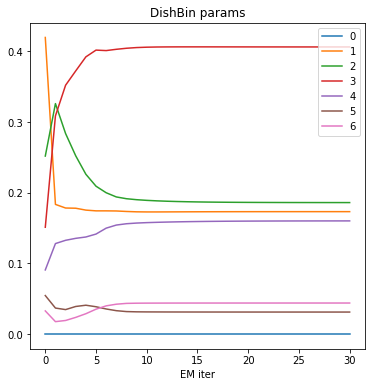

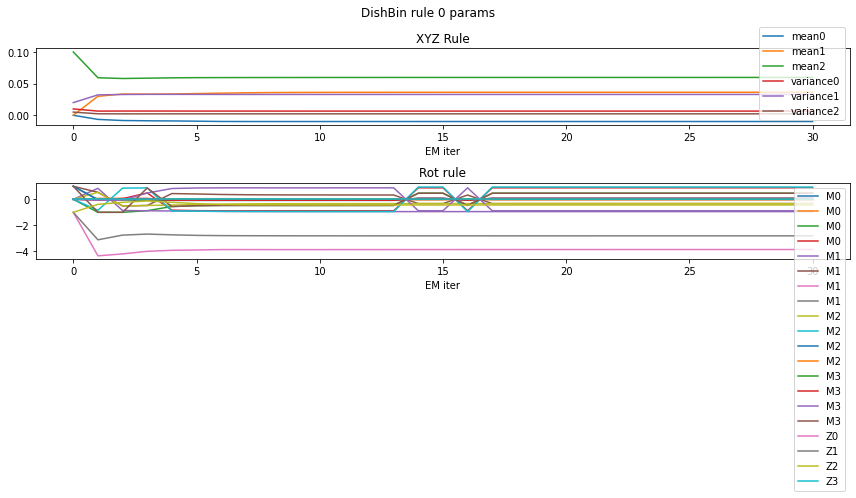

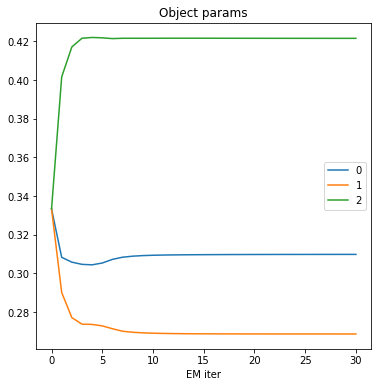

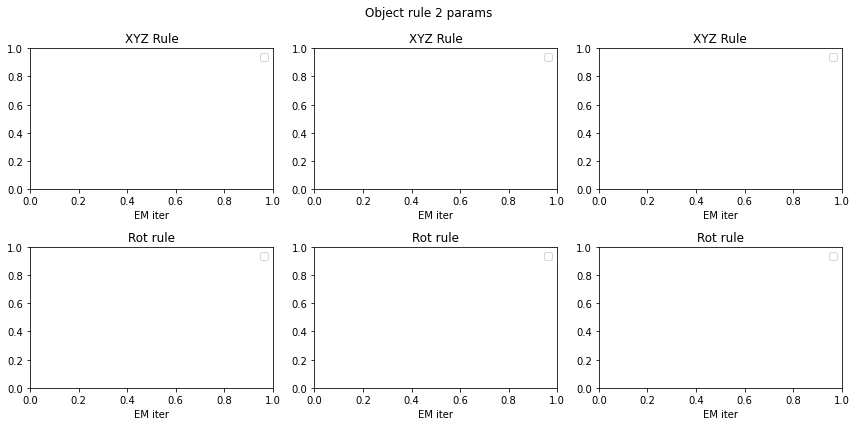

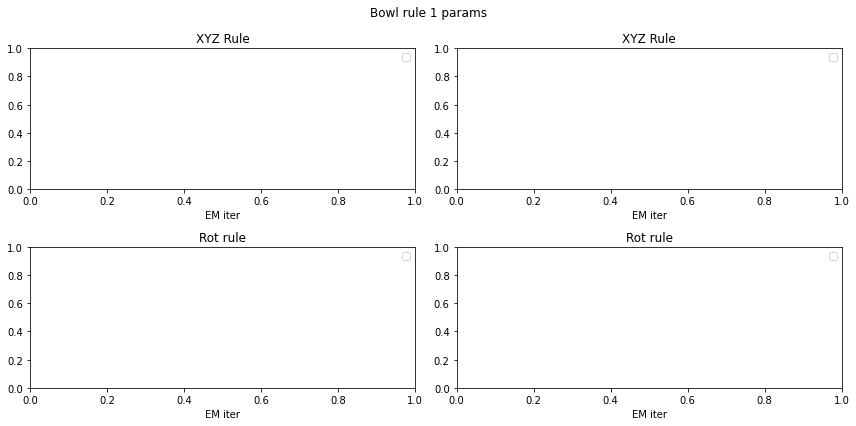

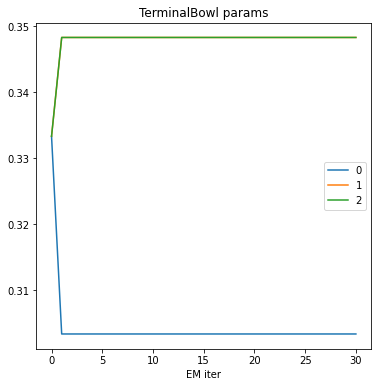

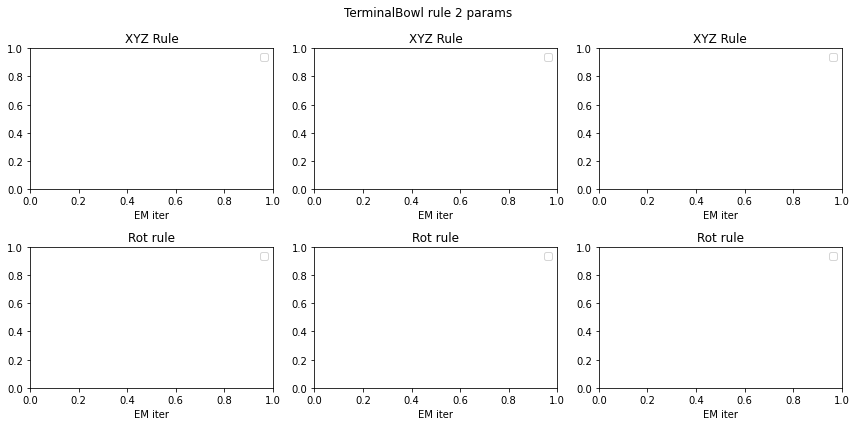

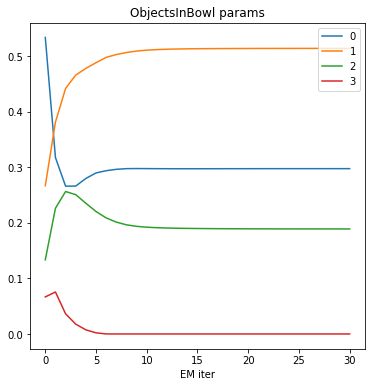

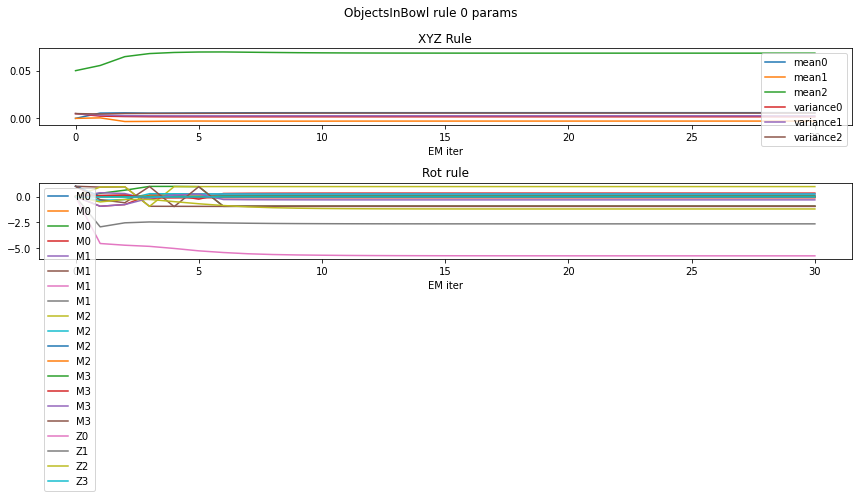

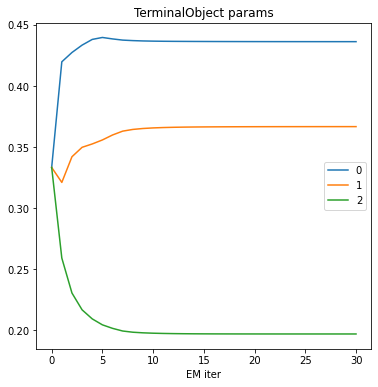

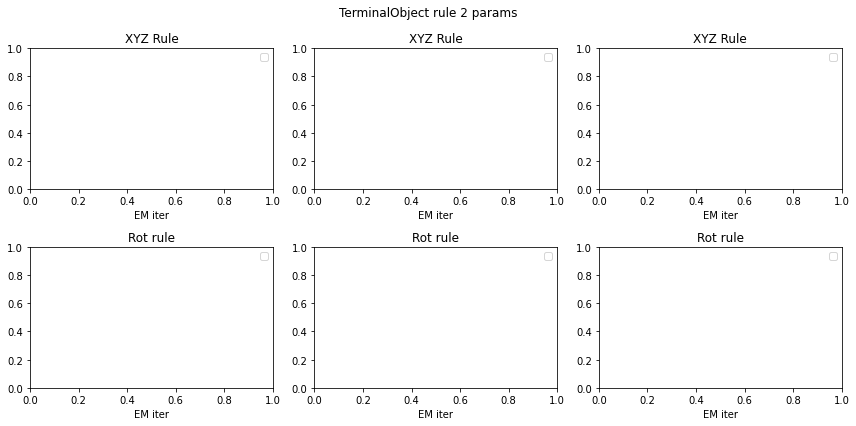

In [14]:
for node_type_to_plot in [DishBin, Object, Bowl, TerminalBowl, ObjectsInBowl, TerminalObject]:
    print(node_type_to_plot.__name__, ": ")
    em.plot_grammar_parameter_history(node_type_to_plot)

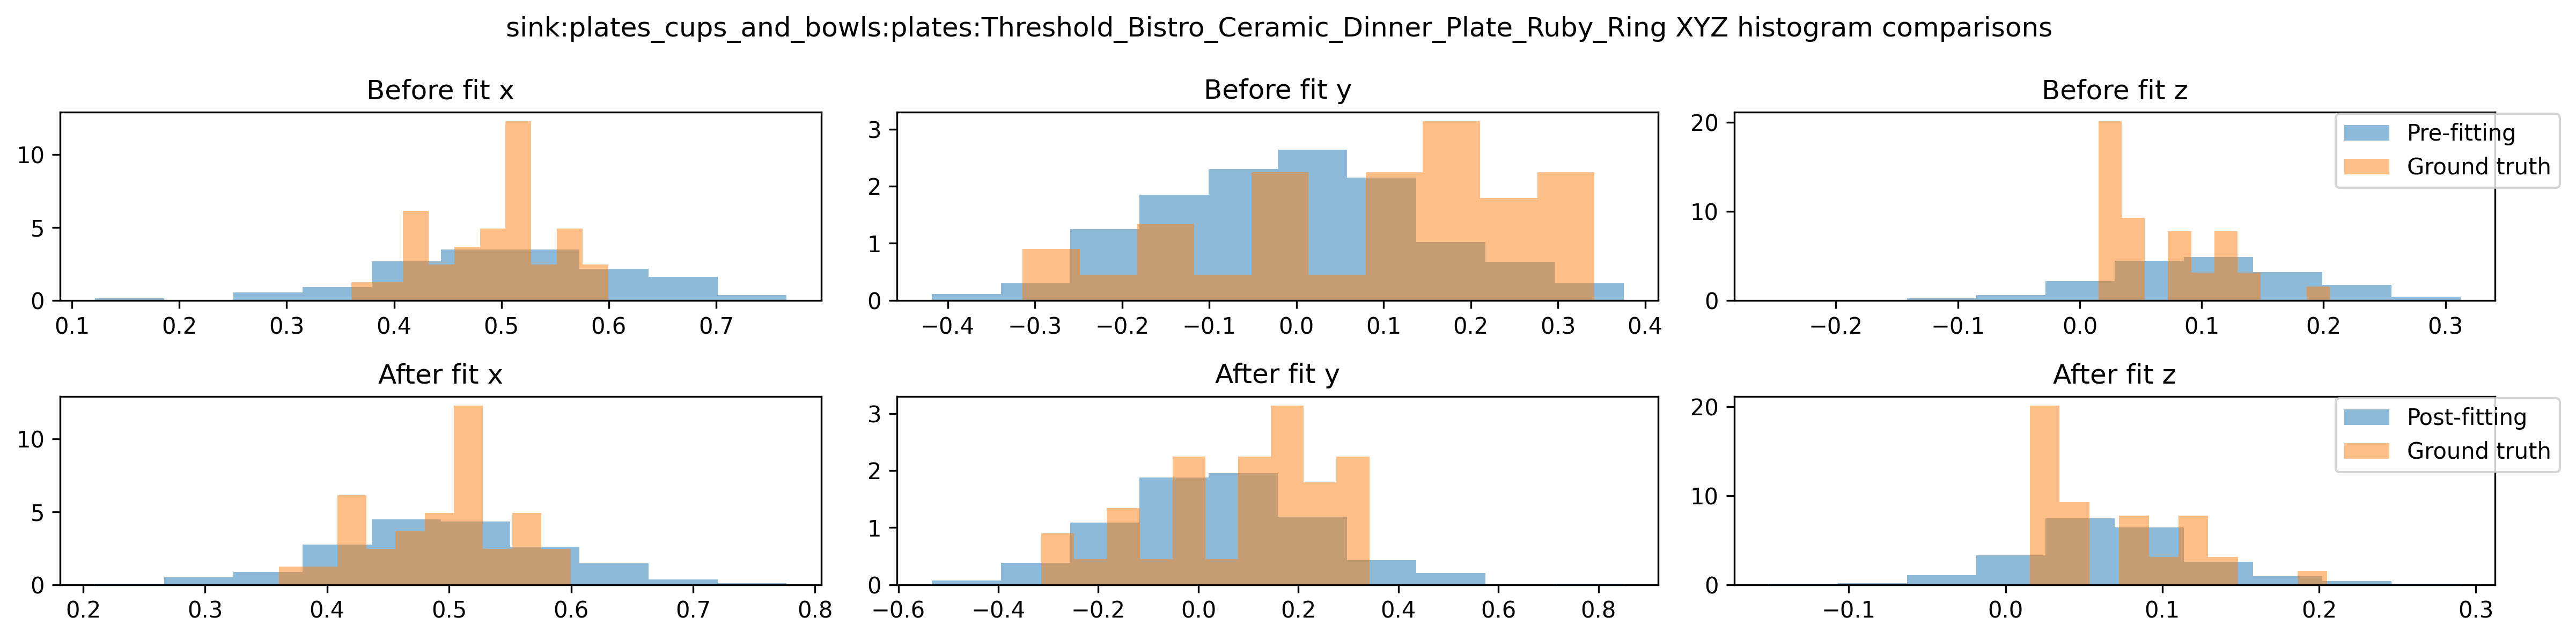

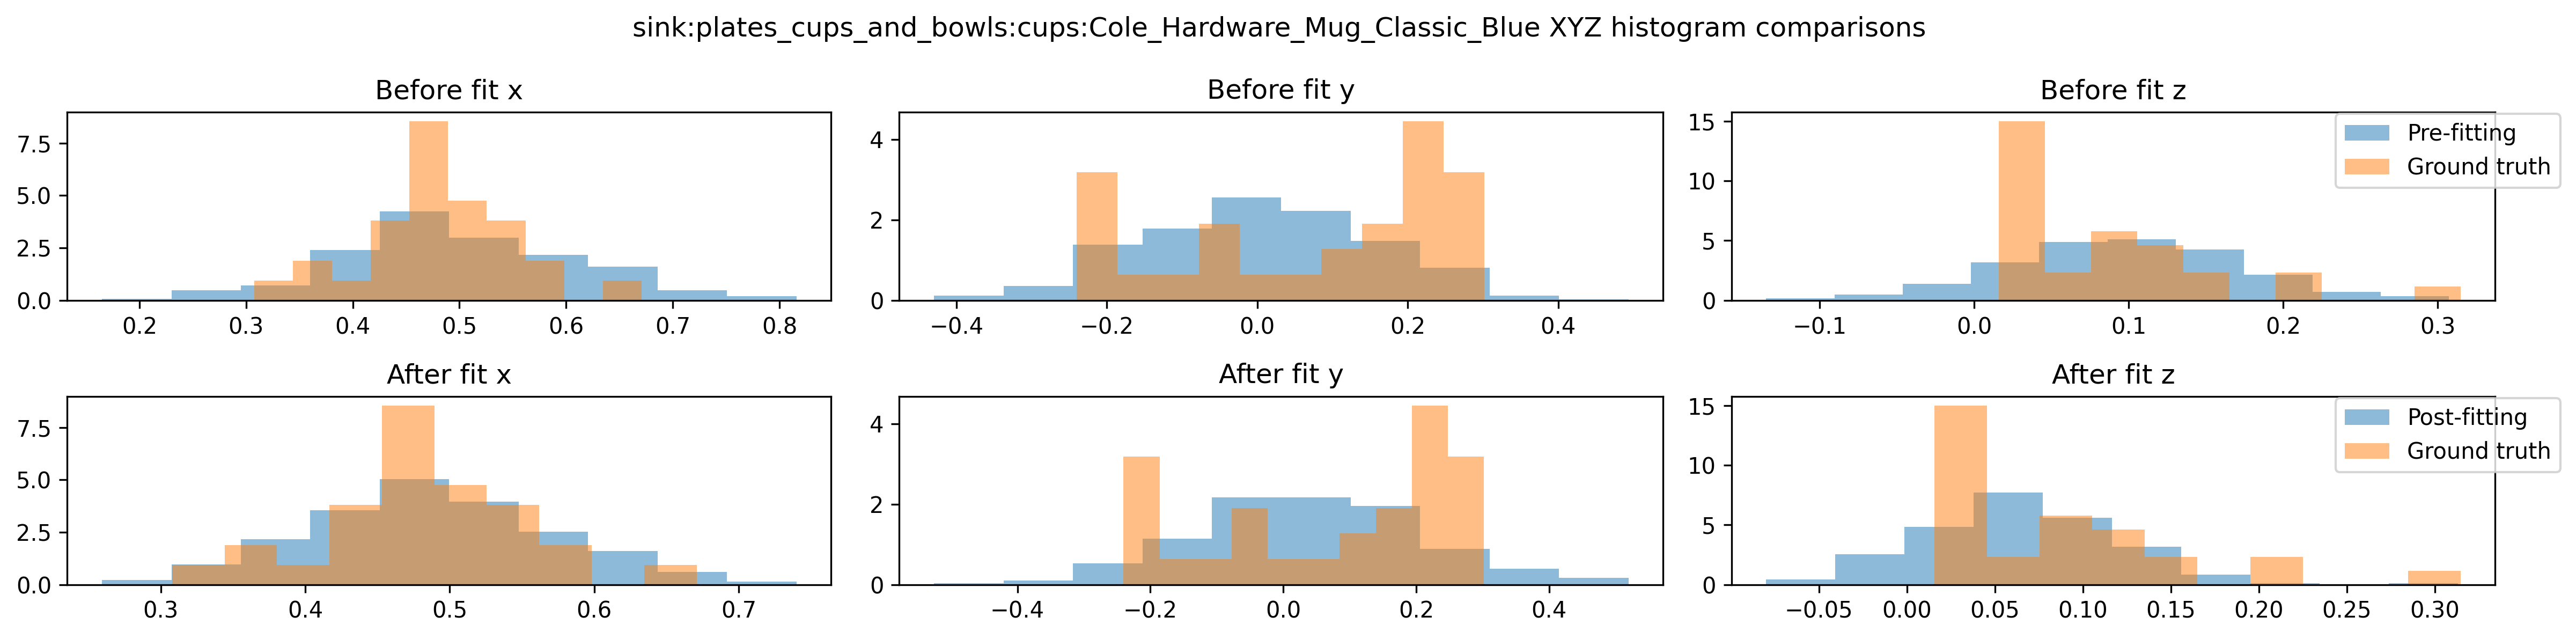

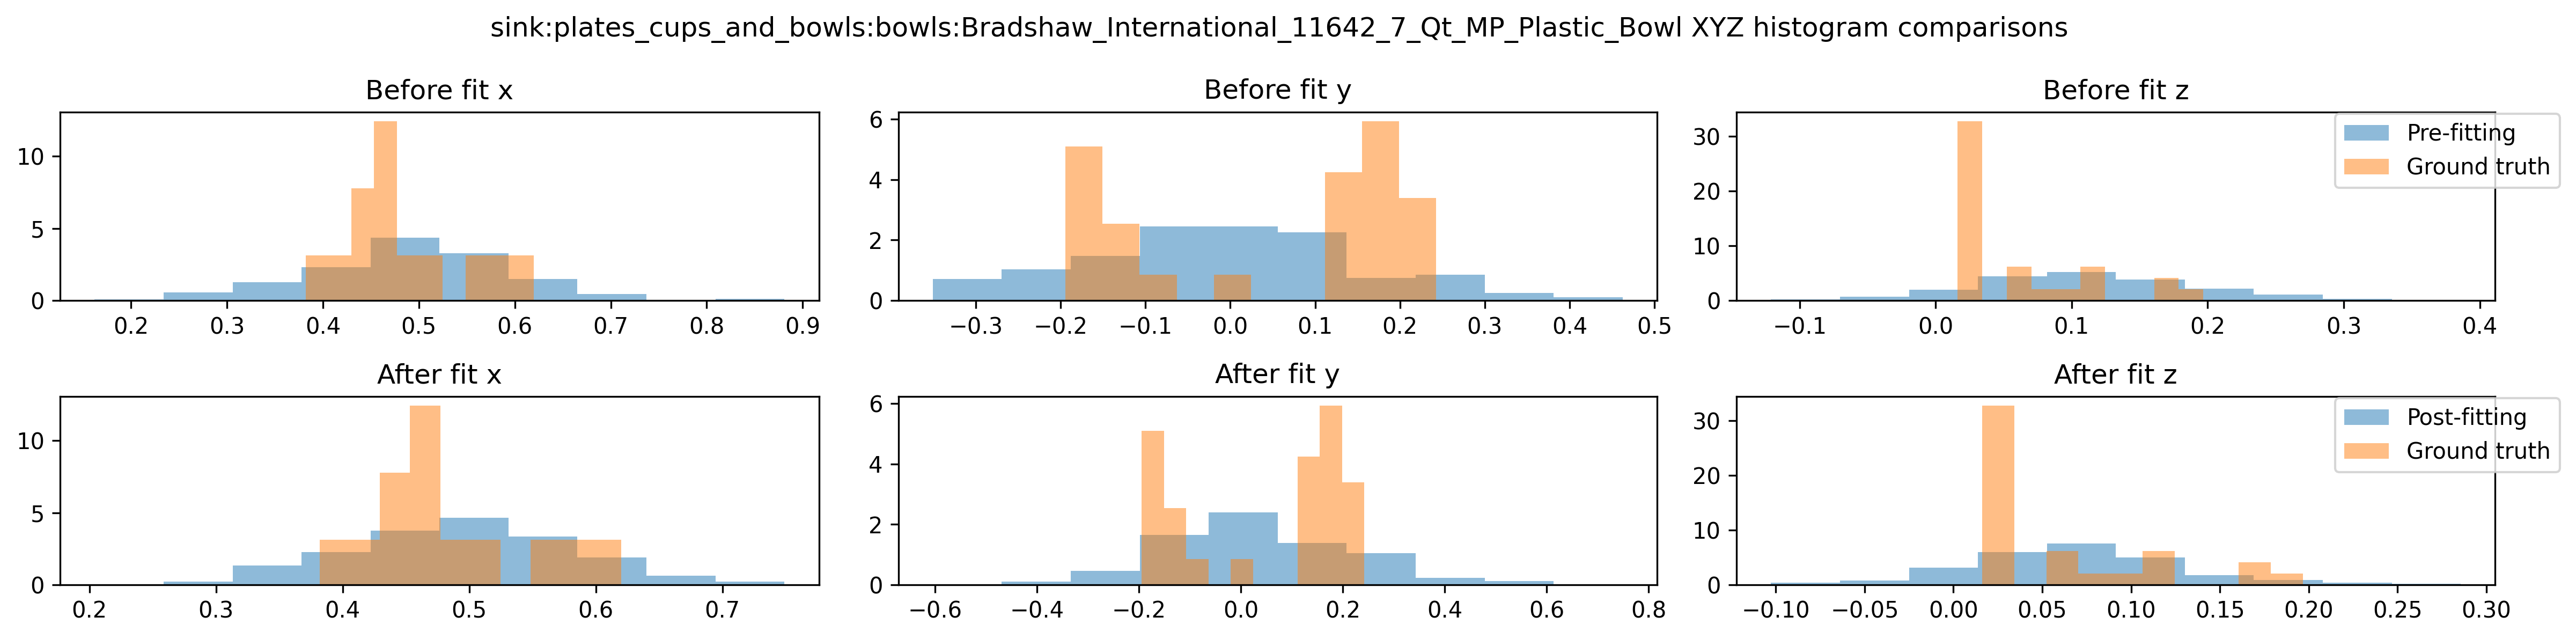

In [15]:
def get_all_node_xyzs(sampled_trees, node_type):
    l = []
    for tree in sampled_trees:
        for node in tree:
            if isinstance(node, node_type):
                l.append(node.translation.detach().cpu().numpy())
    return np.stack(l)
def plot_post_fit_tree_samples(em, N_samples=100):
    pre_fit_samples= []
    em.grammar.load_state_dict(em.grammar_iters[0])
    for k in range(N_samples):
        pre_fit_samples.append(em.grammar.sample_tree(detach=True))
    fit_samples = []
    em.grammar.load_state_dict(em.grammar_iters[-1])
    for k in range(N_samples):
        fit_samples.append(em.grammar.sample_tree(detach=True))

    for node_type in [PlateModels[0], CupModels[0], BowlModels[0]]:
        plt.figure(dpi=300).set_size_inches(16, 4)
        plt.suptitle("%s XYZ histogram comparisons" % node_type.__name__)

        gt_l = get_all_node_xyzs([SceneTree.make_from_observed_nodes(sample) for sample in observed_node_sets], node_type)
        fit_l = get_all_node_xyzs([sample for sample in fit_samples], node_type)
        pre_fit_l = get_all_node_xyzs([sample for sample in pre_fit_samples], node_type)
        # Pre fit
        for k in range(3):
            plt.subplot(2, 3, k+1)
            plt.title("Before fit %s" % "xyz"[k:(k+1)])
            plt.hist(pre_fit_l[:, k], label="Pre-fitting", alpha=0.5, density=True)
            plt.hist(gt_l[:, k], label="Ground truth", alpha=0.5, density=True)
            if k == 2:
                plt.legend(bbox_to_anchor=(1.1, 1.05))

        for k in range(3):
            plt.subplot(2, 3, k+1+3)
            plt.title("After fit %s" % "xyz"[k:(k+1)])
            plt.hist(fit_l[:, k], label="Post-fitting", alpha=0.5, density=True)
            plt.hist(gt_l[:, k], label="Ground truth", alpha=0.5, density=True)
            if k == 2:
                plt.legend(bbox_to_anchor=(1.1, 1.05))
        plt.tight_layout()
plot_post_fit_tree_samples(em, N_samples=1000)

In [16]:
# Draw some samples from the fit posterior
vis["fit_samples"].delete()
for k in range(5):
    tree = grammar.sample_tree(detach=True)
    draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="fit_samples/%d/contents" % k)
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="fit_samples/%d/structure" % k)

# Test parsing a scene

In [77]:
# Set up grammar
grammar = SpatialSceneGrammar(
    root_node_type = DishBin,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.5, 0., 0.]))
)
grammar.load_state_dict(torch.load("fit_grammar.torch"))

<All keys matched successfully>

In [135]:
# Parse that dummy observation; it should have only one unique parse, since there's only one
# object.
# Outlier scenes:
# 0: Stacked on side
# 1: Overflowing sink
# 2: Plates outside bin, score -31.96
# 3: Supertower of stuff, score -37.82
# 4: Overstuffed bowl
# 5: Bowl not in sink, -11.9
# 6: Dishes against unusual side

# Inlier scenes of note:
# 61: score -22.8
trees = infer_mle_tree_with_mip_from_proposals(
    grammar, observed_node_sets_outliers[5], {}, verbose=0, N_solutions=1, max_recursion_depth=10
)
vis["parses"].delete()
for k, tree in enumerate(trees[:1]):
    if k == 0:
        draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="parses/contents/%d" % k)
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="parses/structure/%d" % k,
                                      alpha=0.25, node_sphere_size=0.02, linewidth=10, with_triad=False,
                                        color_by_score=[-10, 10])
    print("Computed score %f" % tree.score(verbose=0))

Node score:  tensor(-1.6824)
Rule score:  tensor([-3.7079])
Rule score:  tensor([-3.8713])
Node score:  tensor(-1.3144)
Rule score:  tensor(0.)
Node score:  tensor(-1.3144)
Rule score:  tensor(0.)
Node score:  tensor(0.)
Rule score:  tensor(0.)
Rule score:  tensor(0.)
Node score:  tensor(0.)
Rule score:  tensor(0.)
Rule score:  tensor(0.)
Node score:  tensor(-1.1928)
Rule score:  tensor(0.)
Node score:  tensor(-1.6665)
Rule score:  tensor([4.5058])
Rule score:  tensor([3.5747])
Node score:  tensor(-1.1928)
Rule score:  tensor(0.)
Node score:  tensor(-0.6661)
Rule score:  tensor([2.7973])
Node score:  tensor([0.])
Node score:  tensor(-1.0031)
Rule score:  tensor(0.)
Node score:  tensor(-1.0031)
Rule score:  tensor(0.)
Node score:  tensor([0.])
Node score:  tensor(-1.0031)
Rule score:  tensor(0.)
Node score:  tensor(-1.0546)
Rule score:  tensor(0.)
Node score:  tensor(-1.0546)
Rule score:  tensor(0.)
Node score:  tensor(-1.0546)
Rule score:  tensor(0.)
Node score:  tensor([0.])
Node scor

# Parse all scenes before and after fitting

In [91]:
# Parse all scenes in dataset, and return by best score.
# Parse that dummy observation; it should have only one unique parse, since there's only one
# object.
pyro.set_rng_seed(42)
grammar = SpatialSceneGrammar(
    root_node_type = DishBin,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.5, 0., 0.]))
)

def get_scores_for_all_scenes(node_sets):
    parses = get_map_trees_for_observed_node_sets(grammar, node_sets, N_solutions=1, num_workers=10, tqdm=tqdm)
    parses = [parse[0] for parse in parses]
    scores = torch.stack([parse.score() for parse in parses]).detach().numpy()
    return scores

print("Getting before-fit scores")
scores_before_fit = get_scores_for_all_scenes(observed_node_sets)
scores_before_fit_outliers = get_scores_for_all_scenes(observed_node_sets_outliers)

print("Getting after-fit scores")
grammar.load_state_dict(torch.load("fit_grammar.torch"))
scores_after_fit = get_scores_for_all_scenes(observed_node_sets)
scores_after_fit_outliers = get_scores_for_all_scenes(observed_node_sets_outliers)

Getting before-fit scores


Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/1:   0%|          | 0/7 [00:00<?, ?it/s]

Getting after-fit scores


Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/1:   0%|          | 0/7 [00:00<?, ?it/s]

Mean log-evidence before fit: -10.410723 inlier, -21.969171 outlier
Mean log-evidence after fit: -5.295745 inlier, -25.956491 outlier


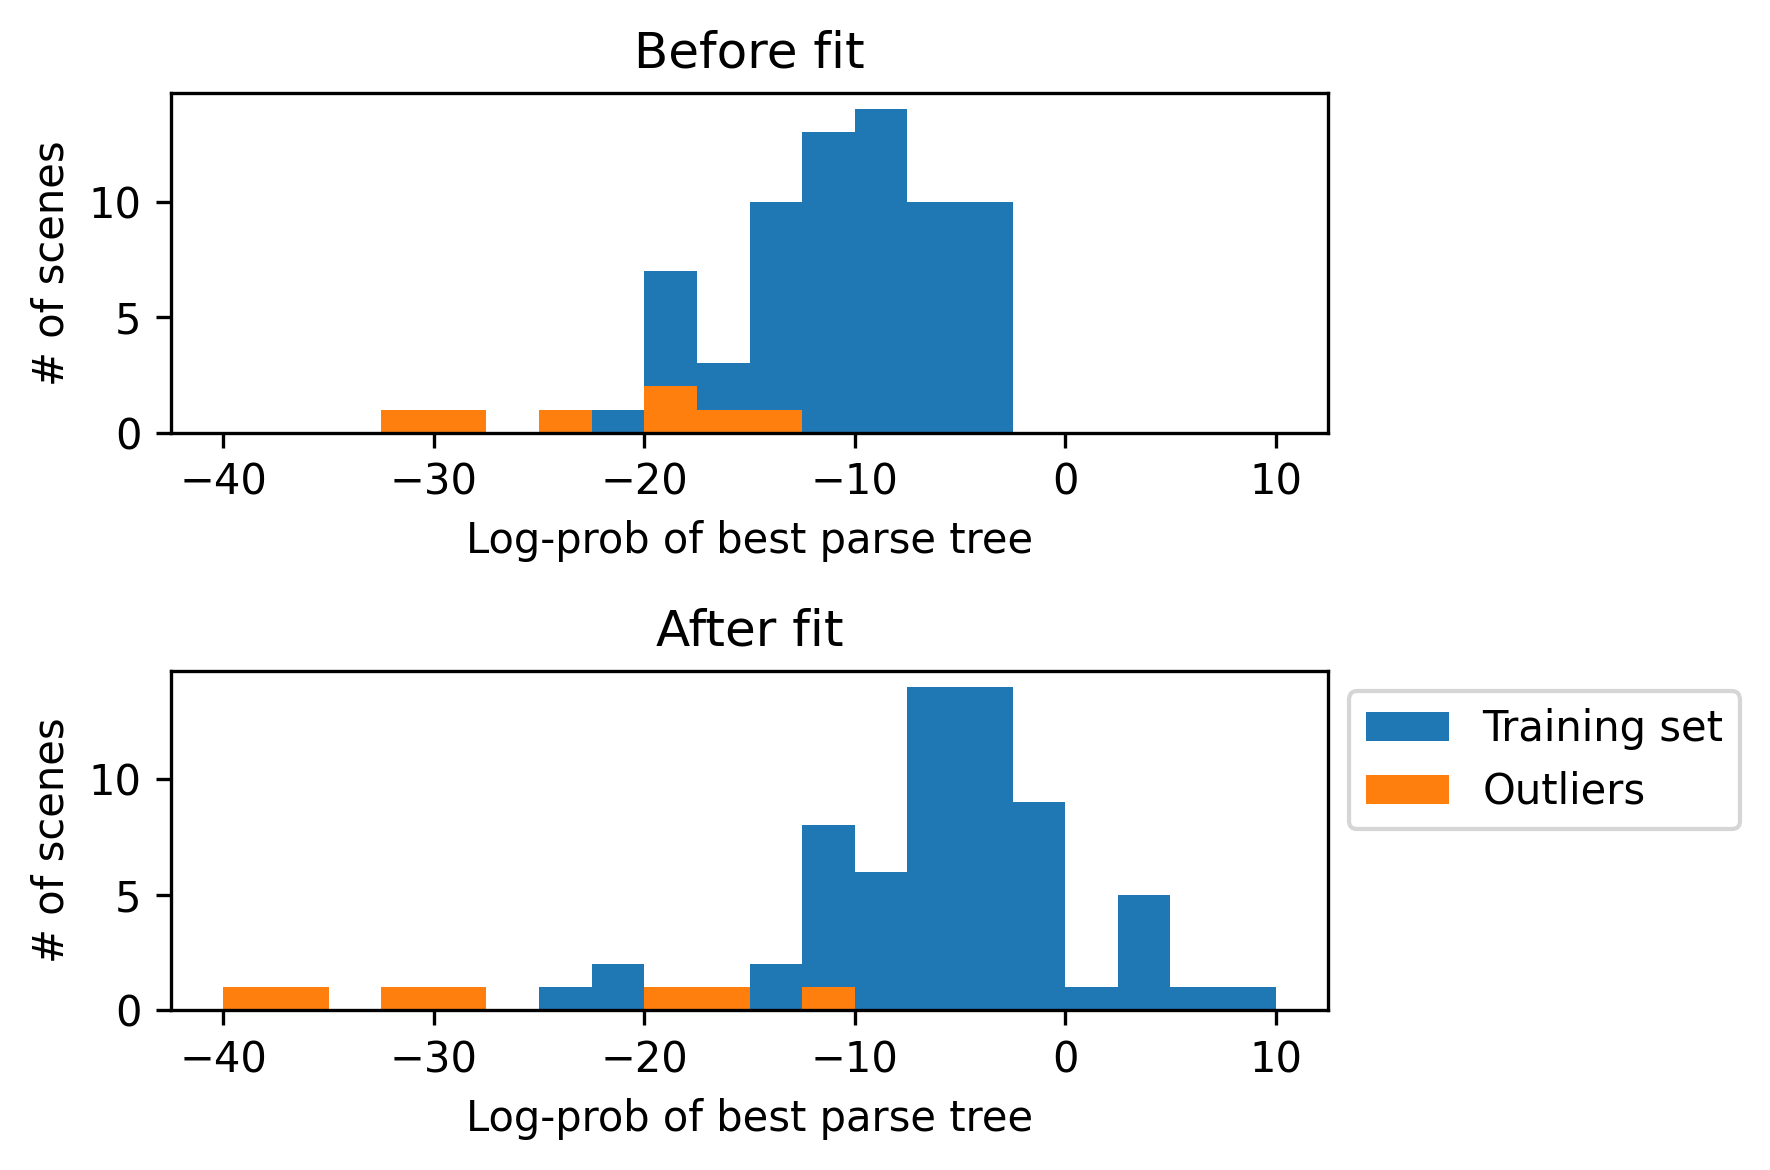

In [107]:
print("Mean log-evidence before fit: %f inlier, %f outlier" % (
    np.mean(scores_before_fit), np.mean(scores_before_fit_outliers)
))
print("Mean log-evidence after fit: %f inlier, %f outlier" % (
    np.mean(scores_after_fit), np.mean(scores_after_fit_outliers)
))

plt.figure(dpi=300).set_size_inches(6, 4)
plt.subplot(2, 1, 1)
N_bins = 20
xrange = (-40, 10)
plt.title("Before fit")
plt.hist(scores_before_fit, bins=N_bins, range=xrange, label="Training set")
plt.hist(scores_before_fit_outliers, bins=N_bins, range=xrange, label="Outliers")
plt.xlabel("Log-prob of best parse tree")
plt.ylabel("# of scenes")

plt.subplot(2, 1, 2)
plt.title("After fit")
plt.hist(scores_after_fit, bins=N_bins, range=xrange, label="Training set")
plt.hist(scores_after_fit_outliers, bins=N_bins, range=xrange, label="Outliers")
plt.xlabel("Log-prob of best parse tree")
plt.ylabel("# of scenes")

plt.legend(bbox_to_anchor=[1, 1])

plt.tight_layout()

Ranking:  [[61]
 [48]
 [65]
 [38]
 [42]
 [52]
 [14]
 [57]
 [55]
 [ 0]
 [35]
 [11]
 [37]
 [41]
 [50]
 [63]
 [16]
 [17]
 [ 7]
 [ 4]
 [ 1]
 [13]
 [43]
 [18]
 [30]
 [59]
 [15]
 [ 2]
 [33]
 [ 3]
 [56]
 [60]
 [58]
 [45]
 [54]
 [62]
 [44]
 [64]
 [66]
 [32]
 [39]
 [23]
 [21]
 [36]
 [ 8]
 [25]
 [67]
 [24]
 [27]
 [10]
 [ 9]
 [46]
 [ 6]
 [28]
 [29]
 [53]
 [22]
 [26]
 [31]
 [47]
 [12]
 [20]
 [ 5]
 [51]
 [34]
 [19]
 [40]
 [49]]
<spatial_scene_grammars_examples.dish_bin.grammar.DishBin object at 0x7fc861035e48> :  -1.7538565508611104
XYZ:  3.939328737615451
Rot:  -3.320453595456226
<spatial_scene_grammars_examples.dish_bin.grammar.DishBin object at 0x7fc861035e48>  ->  <spatial_scene_grammars_examples.dish_bin.grammar.Object object at 0x7fc86103e668> :  0.6188751421592249
<spatial_scene_grammars_examples.dish_bin.grammar.Object object at 0x7fc86103e668> :  -0.8638009842286771
XYZ:  0.0
Rot:  0.0
<spatial_scene_grammars_examples.dish_bin.grammar.Object object at 0x7fc86103e668>  ->  <spatial_scene_gr

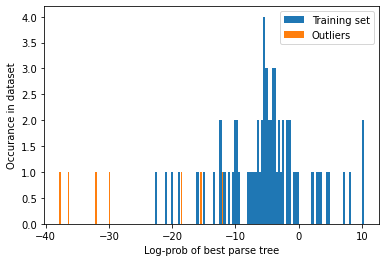

In [80]:
inds_ascending = np.argsort(scores_after_fit, axis=0)
print("Ranking: ", inds_ascending)